## Use the Keras Library to build a Multi-Layer Perceptron Model on the Boston Housing dataset

- The Boston Housing dataset comes with the Keras library so use Keras to import it into your notebook. 
- Normalize the data (all features should have roughly the same scale)
- Import the type of model and layers that you will need from Keras.
- Instantiate a model object and use `model.add()` to add layers to your model
- Since this is a regression model you will have a single output node in the final layer.
- Use activation functions that are appropriate for this task
- Compile your model
- Fit your model and report its accuracy in terms of Mean Squared Error
- Use the history object that is returned from model.fit to make graphs of the model's loss or train/validation accuracies by epoch. 
- Run this same data through a linear regression model. Which achieves higher accuracy?
- Do a little bit of feature engineering and see how that affects your neural network model. (you will need to change your model to accept more inputs)
- After feature engineering, which model sees a greater accuracy boost due to the new features?

In [2]:
## import Boston Housing data set

from keras.datasets import boston_housing

(x_train, y_train), (x_test, y_test) = boston_housing.load_data()

57344/57026 [==============================] - 0s 1us/step


In [31]:
# normalize the data (all features should have roughly the same scale)
x_train.shape

(404, 13)

In [24]:
# import models and layers from keras
import numpy as np
from keras.models import Sequential
from keras.layers import Dense, Dropout

np.random.seed(42)

In [74]:
# Instantiate a model object and use model.add() to add layers to your model
model = Sequential()

model.add(Dense(10, input_dim=13, activation='relu'))

model.add(Dense(15, activation='relu'))
model.add(Dense(10, activation='relu'))

model.add(Dense(1, activation='linear'))

In [81]:
# compile model
model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mean_squared_error'])

# Fit your model and report its accuracy in terms of Mean Squared Error
history = model.fit(x_train, y_train, batch_size=10, epochs=1000, validation_split=.1, verbose=0)

# evaluate the model
scores = model.evaluate(x_test, y_test)
print(f"{model.metrics_names[1]}: {scores[1]}")

102/102 [==============================] - 0s 40us/step
mean_squared_error: 26.042628867953432


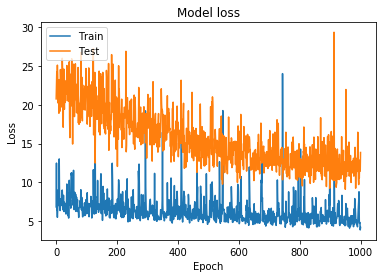

In [82]:
import matplotlib.pyplot as plt

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [61]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score

lin_reg = LinearRegression()

lin_reg.fit(x_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

In [62]:
cross_val_score(lin_reg, x_train, y_train, scoring='neg_mean_squared_error', cv=5).max()

-18.142066421239328

## Use the Keras Library to build an image recognition network using the Fashion-MNIST dataset (also comes with keras)

- Load and preprocess the image data similar to how we preprocessed the MNIST data in class.
- Make sure to one-hot encode your category labels
- Make sure to have your final layer have as many nodes as the number of classes that you want to predict.
- Try different hyperparameters. What is the highest accuracy that you are able to achieve.
- Use the history object that is returned from model.fit to make graphs of the model's loss or train/validation accuracies by epoch. 
- Remember that neural networks fall prey to randomness so you may need to run your model multiple times (or use Cross Validation) in order to tell if a change to a hyperparameter is truly producing better results.

In [ ]:
##### Your Code Here #####

## Stretch Goals:

- Use Hyperparameter Tuning to make the accuracy of your models as high as possible. (error as low as possible)
- Use Cross Validation techniques to get more consistent results with your model.
- Use GridSearchCV to try different combinations of hyperparameters. 
- Start looking into other types of Keras layers for CNNs and RNNs maybe try and build a CNN model for fashion-MNIST to see how the results compare.